## Analyzing Raw Data

In [1]:
## Import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn

PRESSURE_PATH = '/Users/jiujiu/Desktop/caam-495-fluid-flow/New_Data/pressure/'   # pressure data
SATURATION_PATH = '/Users/jiujiu/Desktop/caam-495-fluid-flow/New_Data/saturation/' # saturation data
PRODUCTION_PATH = '/Users/jiujiu/Desktop/caam-495-fluid-flow/New_Data/production/' # production data

def pullseries(PATH, NAME, index_list):
    # input: NAME - 'saturation' or 'pressure'
    data = []
    for i in index_list:
        temp_data = np.loadtxt(PATH+NAME+str(i)+'.txt',delimiter = ',')
        #temp_data = np.reshape(temp_data,(75,60,220),order ='F')
        data.append(temp_data)
    data = np.array(data)
    # restructure data into long array [total snapshots X 13200]
    # total snapshots = n X 75
    # 13200 = total grid points = 60 X 220
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

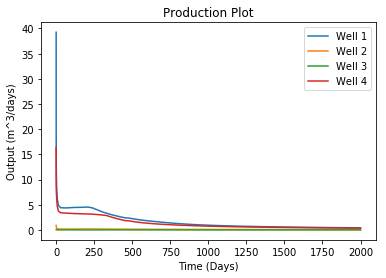

In [2]:
# check production data
Prod_unsized = np.loadtxt(PRODUCTION_PATH + '/production2.txt')
Prod_resized = np.array([Prod_unsized[:,0]/3600.0/24.0, 
                         Prod_unsized[:,1]*3600*24,
                         Prod_unsized[:,2]*3600*24,
                         Prod_unsized[:,3]*3600*24,
                         Prod_unsized[:,4]*3600*24])
well_1 = plt.plot(Prod_resized[0,],Prod_resized[1,],label='Well 1')
well_2 = plt.plot(Prod_resized[0,],Prod_resized[2,],label='Well 2')
well_3 = plt.plot(Prod_resized[0,],Prod_resized[3,],label='Well 3')
well_4 = plt.plot(Prod_resized[0,],Prod_resized[4,],label='Well 4')
plt.title('Production Plot')
# plt.yscale('log')
plt.xlabel('Time (Days)')
plt.ylabel('Output (m^3/days)')
plt.legend()
plt.savefig('Production Plot2.png')

## Scale data and split into sequences for RNN

In [20]:
from sklearn.preprocessing import MinMaxScaler

def create_dataset(DATA,window_len):
    """
    Takes in a timeseries X to create a dataset such that
    
    X_new = [[X_0,X_1,X_2,...,X_window_len],....[X_end-window_len,....,X_end]]
    Y_new = [X_window_len,....X_end]
    """
    X_new = []
    y_new = DATA[window_len:]
    for index in range(len(DATA) - window_len):        
        temp = DATA[index]
        for i in range(1,window_len):
            temp = np.vstack((temp,DATA[index+i]))
        X_new.append(temp)
    X_new = np.stack(X_new)
    y_new = np.stack(y_new)
    return X_new,y_new

def prepare_training_data(TRAIN,lookback):
    # train the standardization
    scaler = MinMaxScaler()
    scaler = scaler.fit(TRAIN)
    print('Min:', scaler.data_min_[0:3], '\nMax: ',scaler.data_max_[0:3])
    normalized = scaler.transform(TRAIN)
    Out_X = []
    Out_y = []
    for i in range(int(len(normalized)/75)):
        X_temp, y_temp = create_dataset(normalized[i*75:(i+1)*75,:],lookback)
        Out_X.append(X_temp)
        Out_y.append(y_temp)
    Out_X = np.concatenate(Out_X,axis = 0)
    Out_y = np.concatenate(Out_y,axis = 0)
    return (Out_X, Out_y), scaler

def prepare_testing_data(TEST,lookback,scaler):
    # train the standardization
    normalized = scaler.transform(TEST)
    Out_X = []
    Out_y = []
    for i in range(int(len(normalized)/75)):
        X_temp, y_temp = create_dataset(normalized[i*75:(i+1)*75,:],lookback)
        Out_X.append(X_temp)
        Out_y.append(y_temp)
    Out_X = np.concatenate(Out_X,axis = 0)
    Out_y = np.concatenate(Out_y,axis = 0)
    return (Out_X, Out_y)




## LSTM-RNN

In [4]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
def trainRNN(lookback,TRAIN,TEST,LSTM_unit):
    # specify Neural Network architecture
#     Dense1_unit = 100
#     LSTM_unit = 30
    # unpack inputs
    X_train, y_train = TRAIN
    X_test, y_test = TEST
    n = X_train.shape[2] # size of input
    if lookback == 1:
        # change expected output shape if lookback is 1
        X_train = np.expand_dims(X_train,axis = 1)
        y_test = np.expand_dims(X_test,axis = 1)
    # build neural net
    model = Sequential()
#     model.add(Dense1_unit,(lookback,n))
#     model.add(Reshape((3, 4), input_shape=(Dense1_unit,)))
    model.add(LSTM(LSTM_unit, activation='relu', input_shape=(lookback, n)))
    model.add(Dense((n)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=20, batch_size=75-lookback, validation_data=(X_test, y_test), verbose=0, shuffle=False)
    # plot history
    plt.figure()
    plt.semilogy(np.array(history.history['loss']), label='Training Error')
    plt.semilogy(np.array(history.history['val_loss']), label='Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    model.summary()
    return model

Using TensorFlow backend.


## Sequential States Test

In [5]:
from numpy import linalg as LA
def updateX(model,X_current,lookback):
    # take in the current X sample and update it using LSTM trained neural net
    # originally [X1 X2 .. X_lookback] -> [X2 .. X_lookback+1]
    X_c_train = np.expand_dims(X_current, axis=0)
    x_plusone = model.predict(X_c_train,batch_size=None, verbose=0, steps=None)
    if lookback == 1:
        X_next = x_plusone
    else:
        X_next = np.vstack((X_current[1:,],x_plusone))
    return X_next,x_plusone

def cumulative_test(TEST,lookback,model,scaler):
    # perform cumulative testing
    X_test, y_test = TEST
    X_current = X_test[0,] # both X_test should be the same
    m = y_test.shape[0]
    i = 0
    errors = np.zeros(m)
    predicted_y = np.zeros(y_test.shape)
    while i < m:
        X_next,y_predicted = updateX(model,X_current,lookback)
        # rescale, optional
        y_test_rescaled = scaler.inverse_transform(y_test)
        y_predicted_rescaled = scaler.inverse_transform(y_predicted)
        # update X and error term
        X_current = X_next
        errors[i] = LA.norm(y_test_rescaled-y_predicted_rescaled)/LA.norm(y_test_rescaled)
        predicted_y[i,:] = y_predicted_rescaled
        i += 1
    return errors, predicted_y

In [6]:
# function to compare resulting sequential states
def animate_compare(y1,y2):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(y1)):    
        ax1.clear()
        ax1.imshow(np.reshape(y1[i,:],(60,220),order ='F'))
        ax2.clear()
        ax2.imshow(np.reshape(y2[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
# plt.title('Water Saturation')
# plt.savefig('Saturation Plot X_1.png')

## Saturation Test

Min: [0.20127 0.20076 0.2006 ] 
Max:  [0.50446 0.4657  0.43366]


<IPython.core.display.Javascript object>


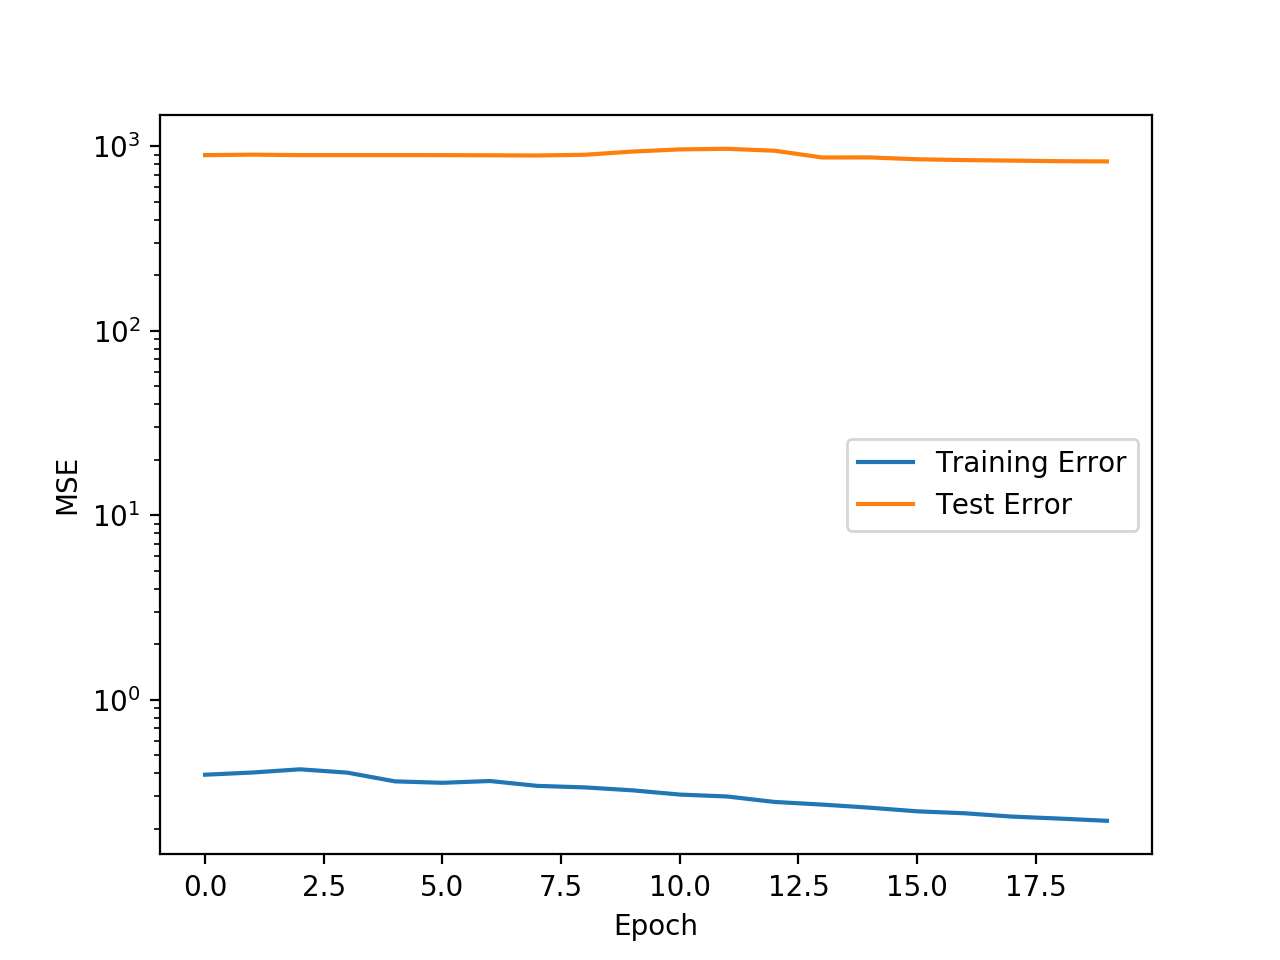

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                2650200   
_________________________________________________________________
dense_3 (Dense)              (None, 13200)             673200    
Total params: 3,323,400
Trainable params: 3,323,400
Non-trainable params: 0
_________________________________________________________________


In [21]:

%matplotlib notebook
STRAIN = pullseries(SATURATION_PATH, 'saturaton', [1, 2])
STEST = pullseries(SATURATION_PATH, 'saturaton', [3])
lookback = 3
Strain,Sscaler = prepare_training_data(STRAIN,lookback)
Stest = prepare_testing_data(STEST,lookback,Sscaler)
Smodel = trainRNN(lookback,Strain,Stest,50)

<IPython.core.display.Javascript object>


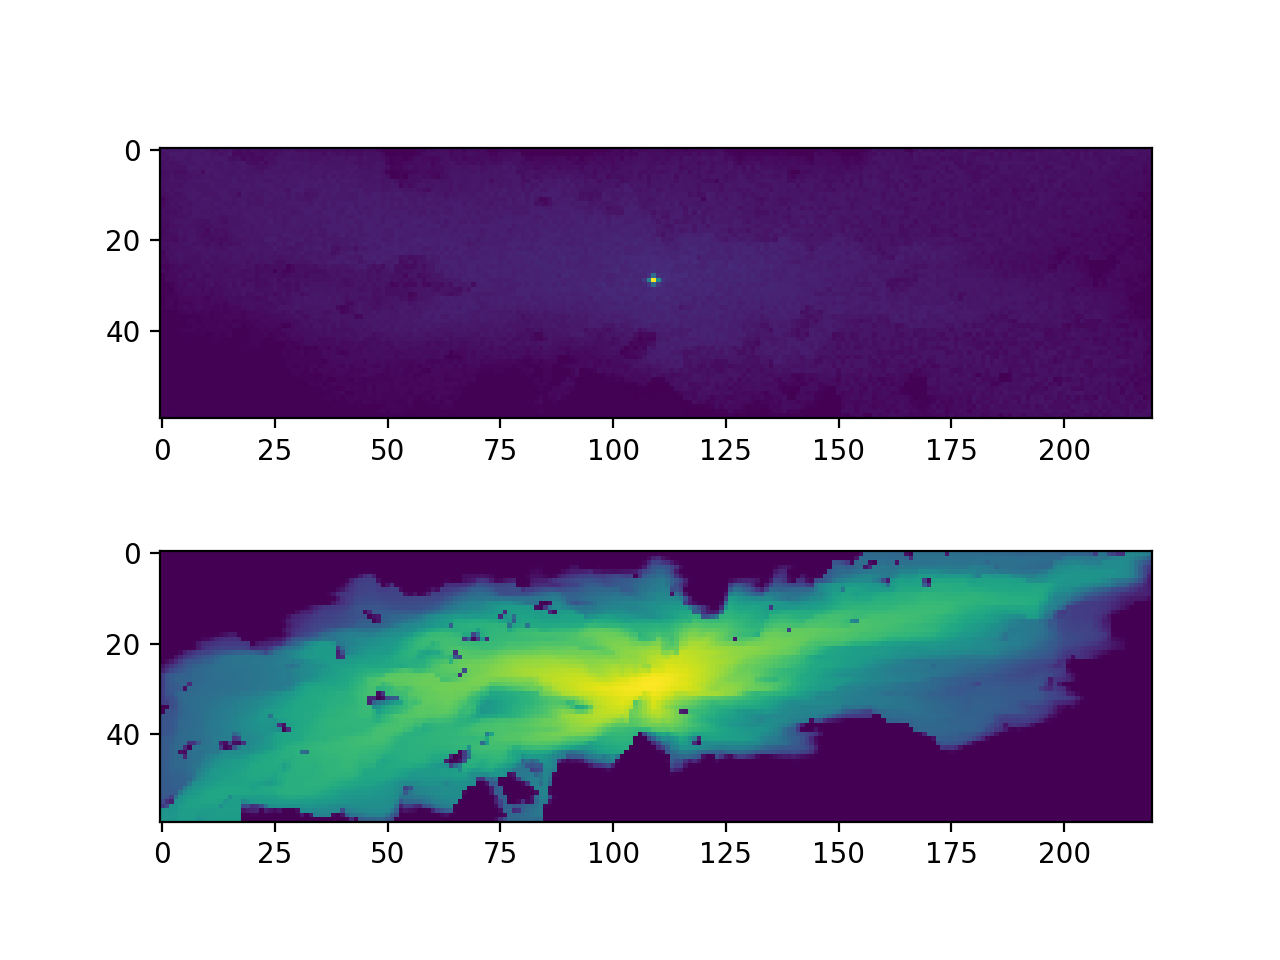

<IPython.core.display.Javascript object>


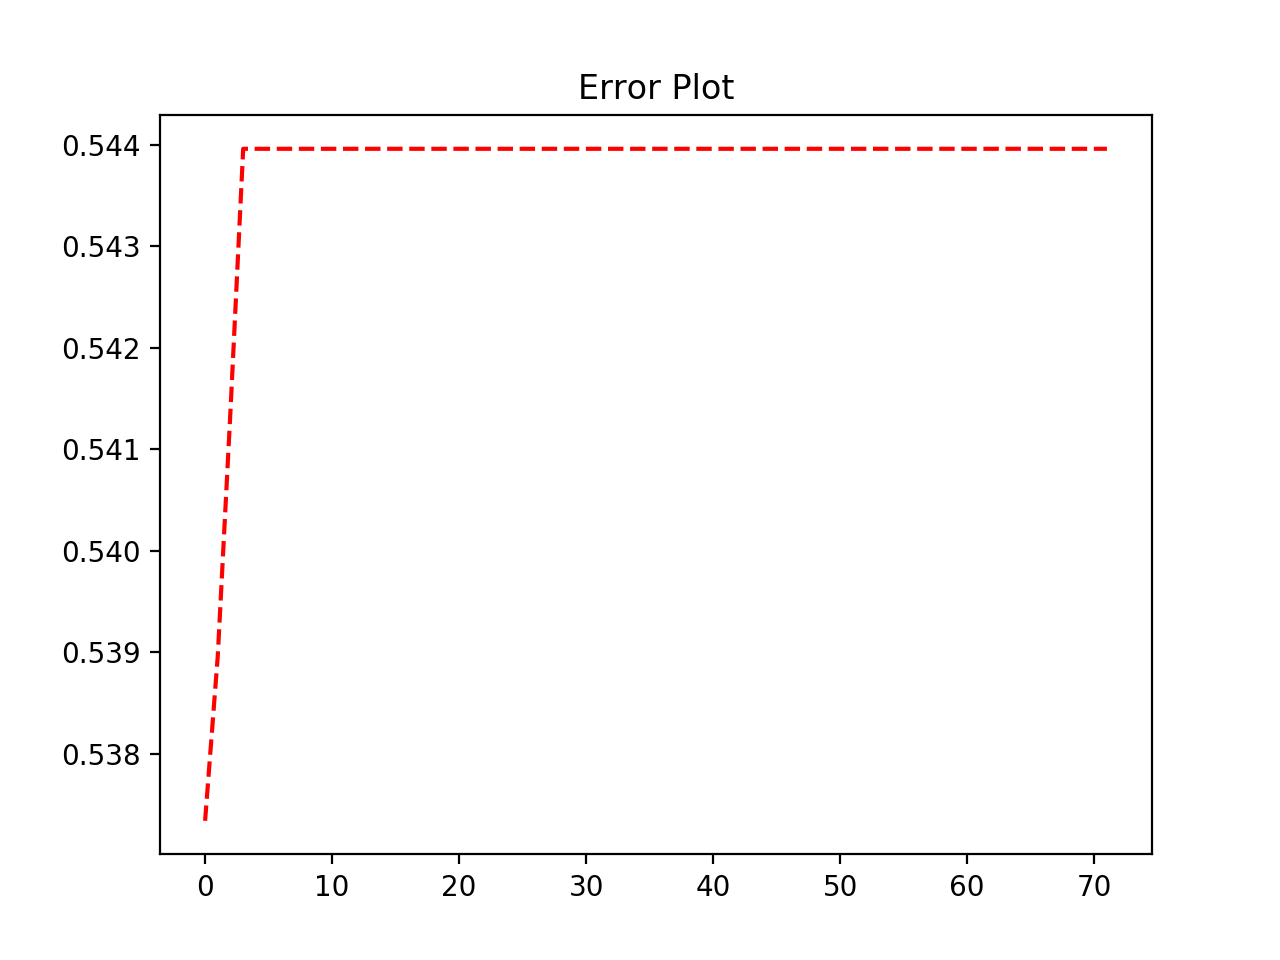

In [22]:
# errors, predicted_y = cumulative_test(Stest,lookback,Smodel,Sscaler)
errors, predicted_y = cumulative_test(Stest,lookback,Smodel,Sscaler)
animate_compare(predicted_y,STEST[lookback:])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')

## Pressure Test

Min: [27586000. 27617000. 27657000.] 
Max:  [30156000. 34839000. 36236000.]


<IPython.core.display.Javascript object>


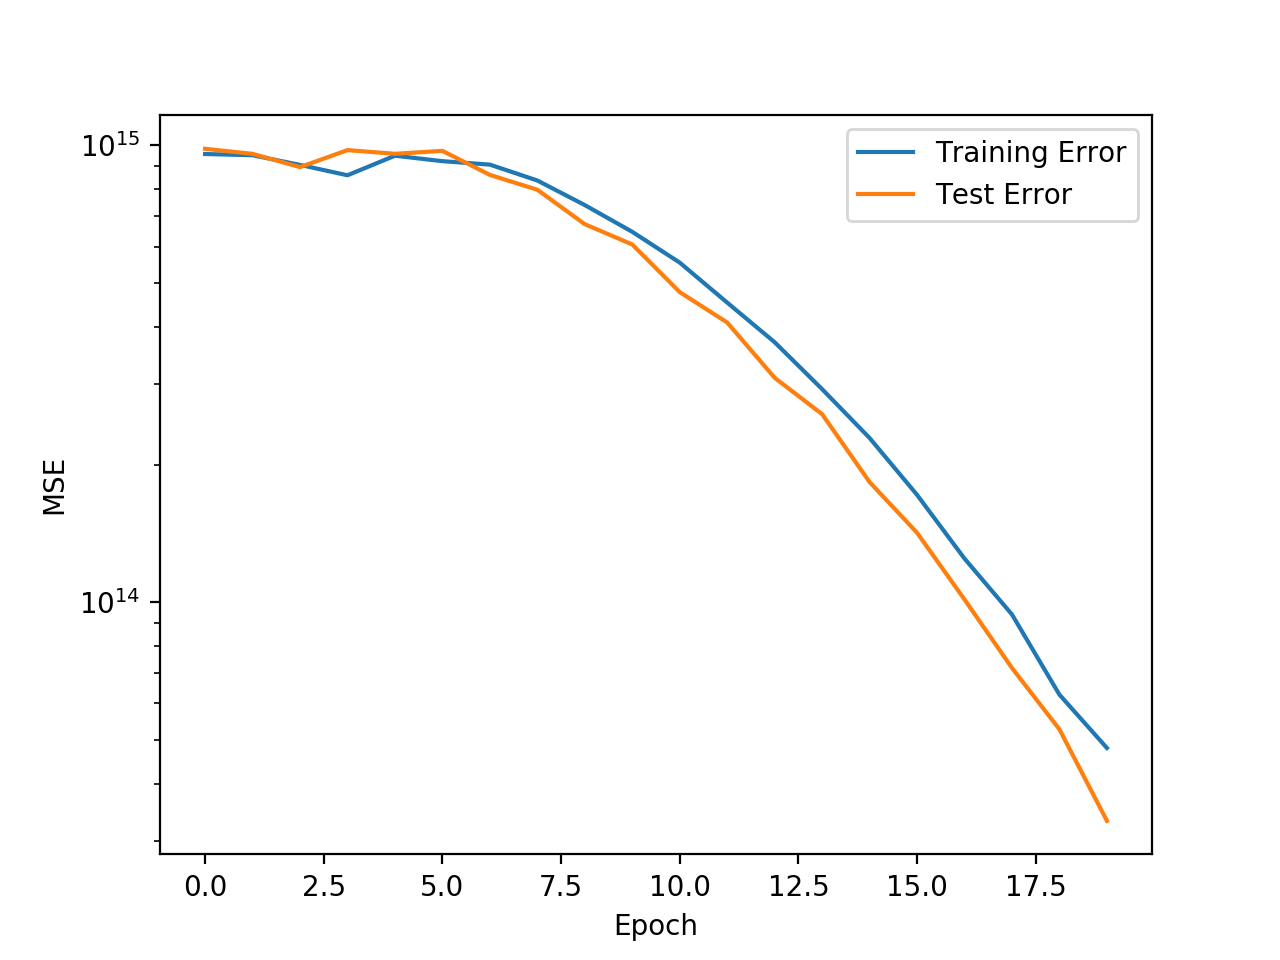

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                2650200   
_________________________________________________________________
dense_2 (Dense)              (None, 13200)             673200    
Total params: 3,323,400
Trainable params: 3,323,400
Non-trainable params: 0
_________________________________________________________________


In [10]:
PTRAIN = pullseries(PRESSURE_PATH, 'pressure', [1, 2])
PTEST = pullseries(PRESSURE_PATH, 'pressure', [3])
lookback = 3
Ptrain,Pscaler = prepare_training_data(PTRAIN,lookback)
Ptest = prepare_testing_data(PTEST,lookback,Sscaler)
Pmodel = trainRNN(lookback,Ptrain,Ptest,50)

<IPython.core.display.Javascript object>


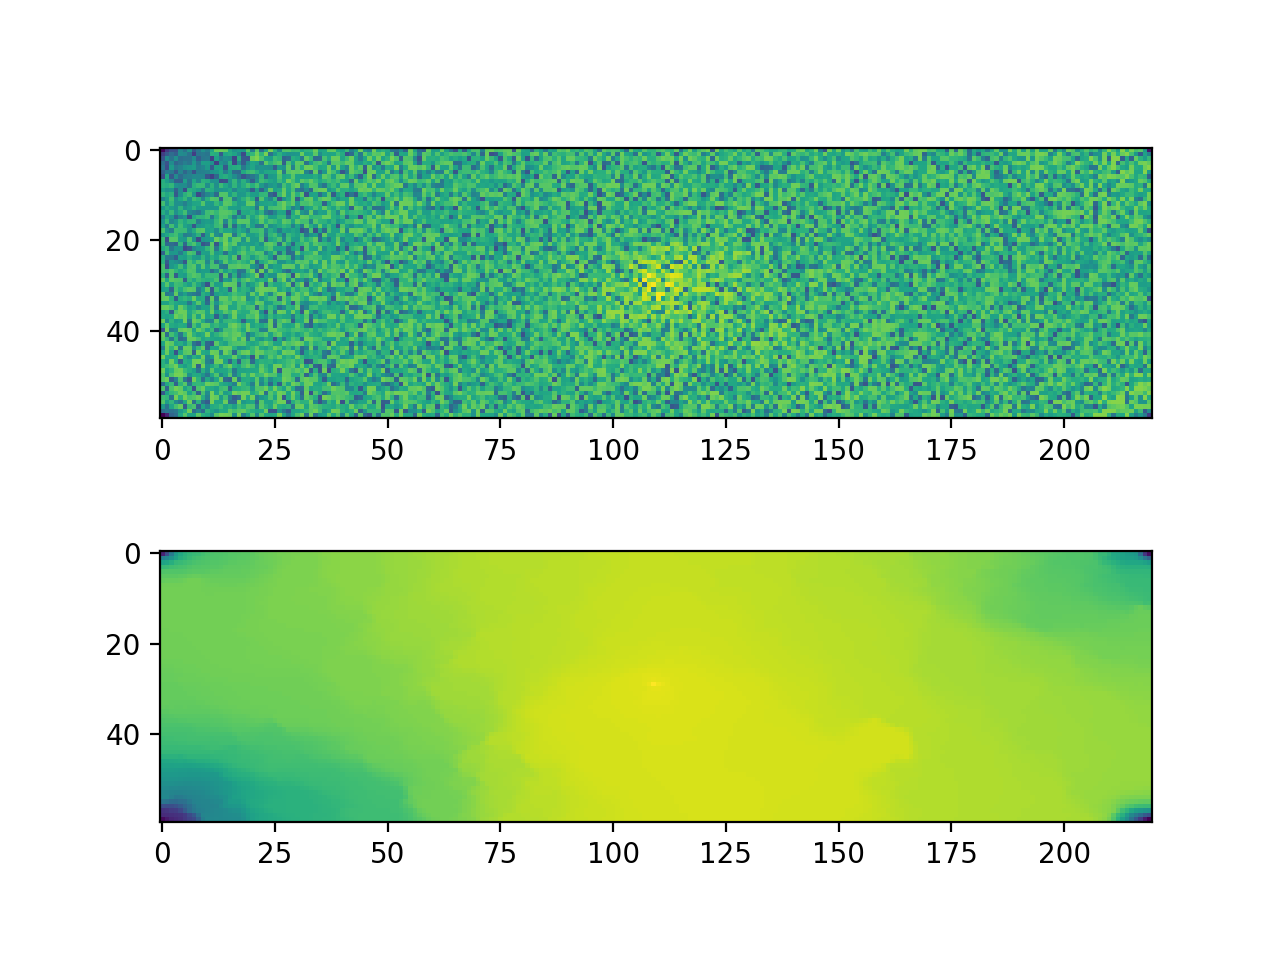

<IPython.core.display.Javascript object>


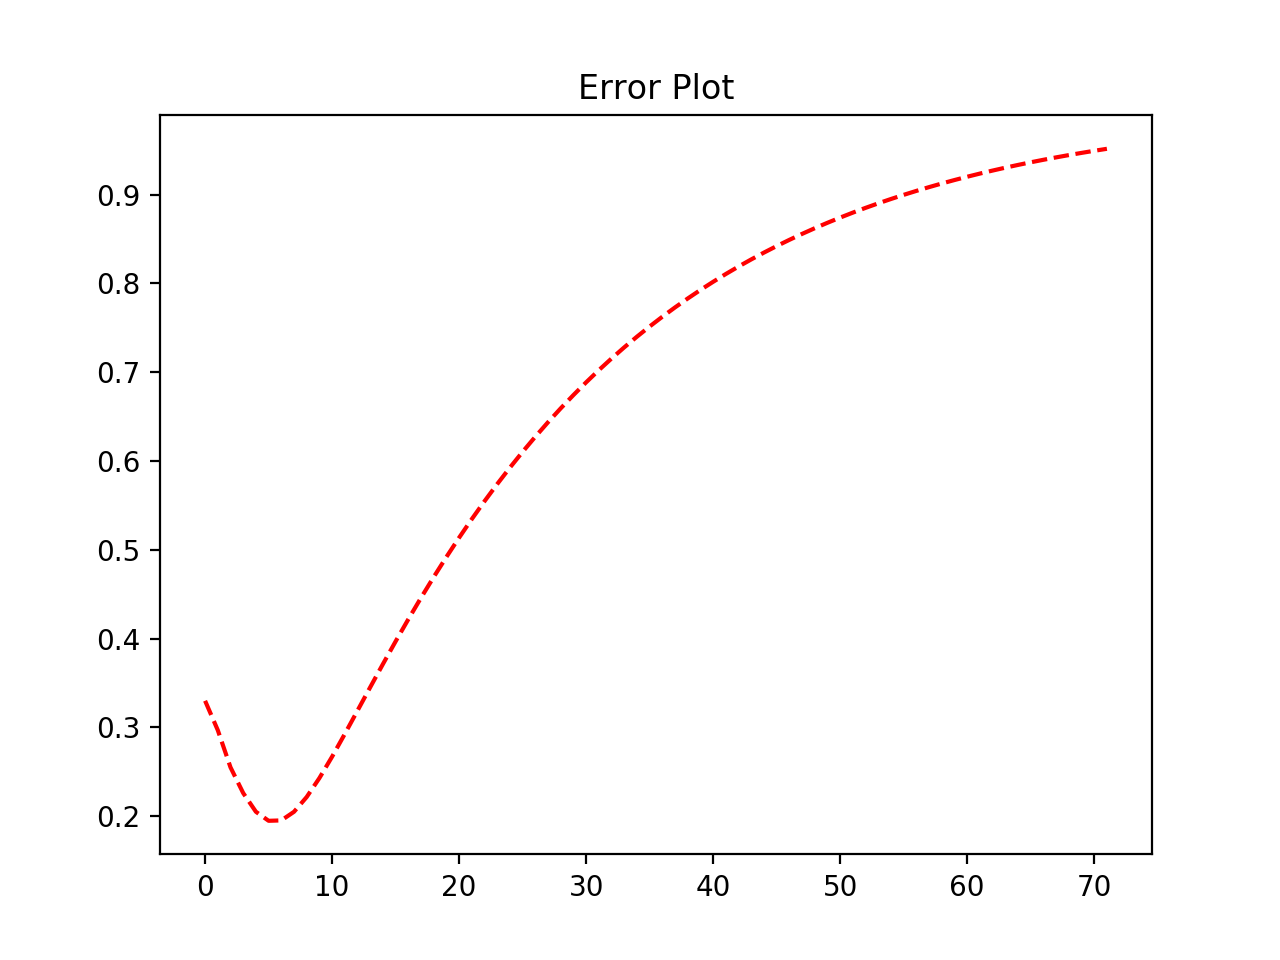

In [11]:
errors, predicted_y = cumulative_test(Ptest,lookback,Pmodel,Pscaler)
animate_compare(predicted_y,PTEST[lookback:])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')

In [14]:
Ptrain

(array([[[30156000., 34839000., 36236000., ..., 32309000., 31439000.,
          28912000.],
         [29826000., 33959000., 35205000., ..., 31194000., 30528000.,
          28596000.],
         [29615000., 33363000., 34494000., ..., 30694000., 30120000.,
          28455000.]],
 
        [[29826000., 33959000., 35205000., ..., 31194000., 30528000.,
          28596000.],
         [29615000., 33363000., 34494000., ..., 30694000., 30120000.,
          28455000.],
         [29456000., 32913000., 33955000., ..., 30317000., 29812000.,
          28349000.]],
 
        [[29615000., 33363000., 34494000., ..., 30694000., 30120000.,
          28455000.],
         [29456000., 32913000., 33955000., ..., 30317000., 29812000.,
          28349000.],
         [29255000., 32340000., 33271000., ..., 29896000., 29469000.,
          28231000.]],
 
        ...,
 
        [[27586000., 27618000., 27661000., ..., 28791000., 28519000.,
          27888000.],
         [27586000., 27618000., 27660000., ..., 28781000

In [19]:
Pscaler.transform(PTRAIN)
Ptrain

(array([[[30156000., 34839000., 36236000., ..., 32309000., 31439000.,
          28912000.],
         [29826000., 33959000., 35205000., ..., 31194000., 30528000.,
          28596000.],
         [29615000., 33363000., 34494000., ..., 30694000., 30120000.,
          28455000.]],
 
        [[29826000., 33959000., 35205000., ..., 31194000., 30528000.,
          28596000.],
         [29615000., 33363000., 34494000., ..., 30694000., 30120000.,
          28455000.],
         [29456000., 32913000., 33955000., ..., 30317000., 29812000.,
          28349000.]],
 
        [[29615000., 33363000., 34494000., ..., 30694000., 30120000.,
          28455000.],
         [29456000., 32913000., 33955000., ..., 30317000., 29812000.,
          28349000.],
         [29255000., 32340000., 33271000., ..., 29896000., 29469000.,
          28231000.]],
 
        ...,
 
        [[27586000., 27618000., 27661000., ..., 28791000., 28519000.,
          27888000.],
         [27586000., 27618000., 27660000., ..., 28781000